In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

In [2]:
def aic(y,y_pred, X):
    
    # Compute the residual sum of squares (RSS)
    RSS = np.sum((y - y_pred)**2)

    # Compute the number of parameters in the model
    k = X.shape[1] + 1

    # Compute the AIC score
    AIC = 2*k - 2*np.log(RSS)

    return AIC

### Loading the data:

In [3]:
data1 = pd.read_csv('1) March 2022 to July 2022.csv')
data2 = pd.read_csv('2) August 2022.csv')
data3 = pd.read_csv('3) Sep 2022 to Oct 2022.csv')
data4 = pd.read_csv('4) Nov 2022 to February 2023.csv')

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046136 entries, 0 to 1046135
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Record ID   589206 non-null  float64
 1   Date Time   589206 non-null  object 
 2   Solar Avg   589118 non-null  float64
 3   Unnamed: 3  80 non-null      float64
dtypes: float64(3), object(1)
memory usage: 31.9+ MB


In [5]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566843 entries, 0 to 566842
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Record ID  566843 non-null  int64 
 1   Date Time  566843 non-null  object
 2   Solar Avg  566843 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.0+ MB


### Adding the for datasets into one big data set:

In [6]:
data = data1.append(data2).append(data3).append(data4)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3153731 entries, 0 to 730723
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Record ID   float64
 1   Date Time   object 
 2   Solar Avg   float64
 3   Unnamed: 3  float64
dtypes: float64(3), object(1)
memory usage: 120.3+ MB


In [8]:
data.isna().sum()

Record ID      456930
Date Time      456930
Solar Avg      457018
Unnamed: 3    3153651
dtype: int64

In [9]:
data = data.drop(['Record ID','Unnamed: 3'], axis=1)
data.dropna(inplace=True)
data['Date Time'] = pd.to_datetime(data['Date Time'])
data.drop_duplicates(subset='Date Time',inplace=True)
data.sort_values(by='Date Time',inplace=True)
data.set_index('Date Time', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 931237 entries, 2022-01-03 00:00:00 to 2023-12-02 23:59:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Solar Avg  931237 non-null  float64
dtypes: float64(1)
memory usage: 14.2 MB


data = data.drop(['Record ID','Unnamed: 3'], axis=1): This line drops two columns named 'Record ID' and 'Unnamed: 3' from the DataFrame data. The axis=1 argument specifies that columns should be dropped.

data.dropna(inplace=True): This line drops all rows from the DataFrame data that contain missing (NaN) values. The inplace=True argument specifies that the DataFrame should be modified in place.

data['Date Time'] = pd.to_datetime(data['Date Time']): This line converts the values in the 'Date Time' column of the DataFrame data to datetime objects using the pd.to_datetime() function. This is done so that the values can be easily sorted and indexed later.

data.drop_duplicates(subset='Date Time',inplace=True): This line drops any rows from the DataFrame data that have duplicate values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.sort_values(by='Date Time',inplace=True): This line sorts the rows of the DataFrame data by the values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.set_index('Date Time', inplace=True): This line sets the 'Date Time' column as the index of the DataFrame data. This means that the DataFrame will be indexed by dates and times, which will be useful for time series analysis.

data.info(): This line prints out some basic information about the DataFrame data, including its shape (number of rows and columns), the data types of its columns, and the number of non-null values in each column.

In [10]:
del data1,data2,data3,data4

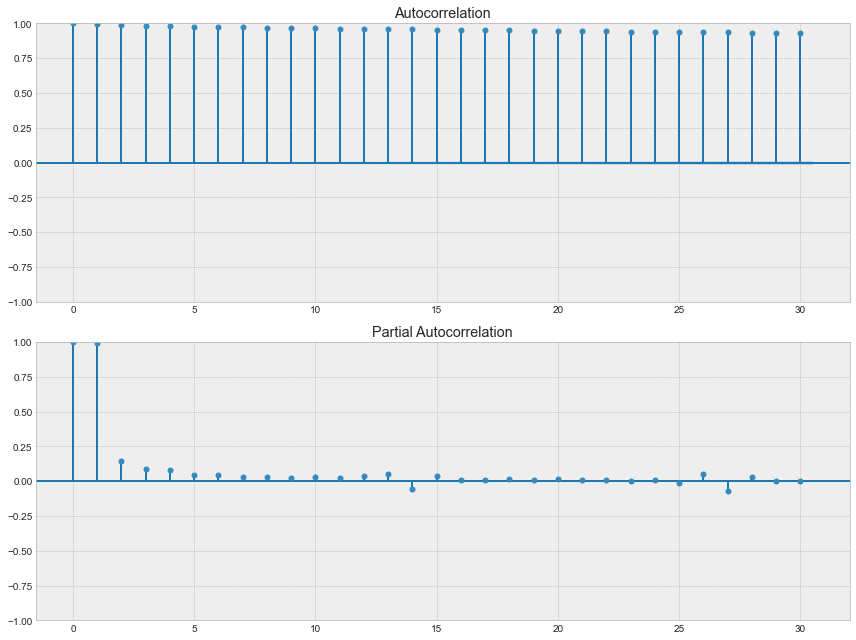

In [11]:
import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

data.sort_index(inplace=True)
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(12, 9))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_pacf(data['Solar Avg'], ax=pacf_ax,lags=30)
    smt.graphics.plot_acf(data['Solar Avg'], ax=acf_ax,lags=30)
    plt.tight_layout()

This code imports necessary libraries and then creates a figure with two subplots to display the autocorrelation and partial autocorrelation functions for a time series dataset. The sort_index method is called to ensure the data is sorted in the correct order, and then the plot_acf and plot_pacf functions are called to generate the desired plots.

In [12]:
# Genrating needed lags:
for i in range(1,15):
    data["lag_{}".format(i)] = data['Solar Avg'].shift(i)
data.dropna(axis=0,inplace=True)
data.head()

,Solar Avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
Date Time,,,,,,,,,,,,,,,
2022-01-03 00:14:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 00:15:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 00:16:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 00:17:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 00:18:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Plotting the correlations:

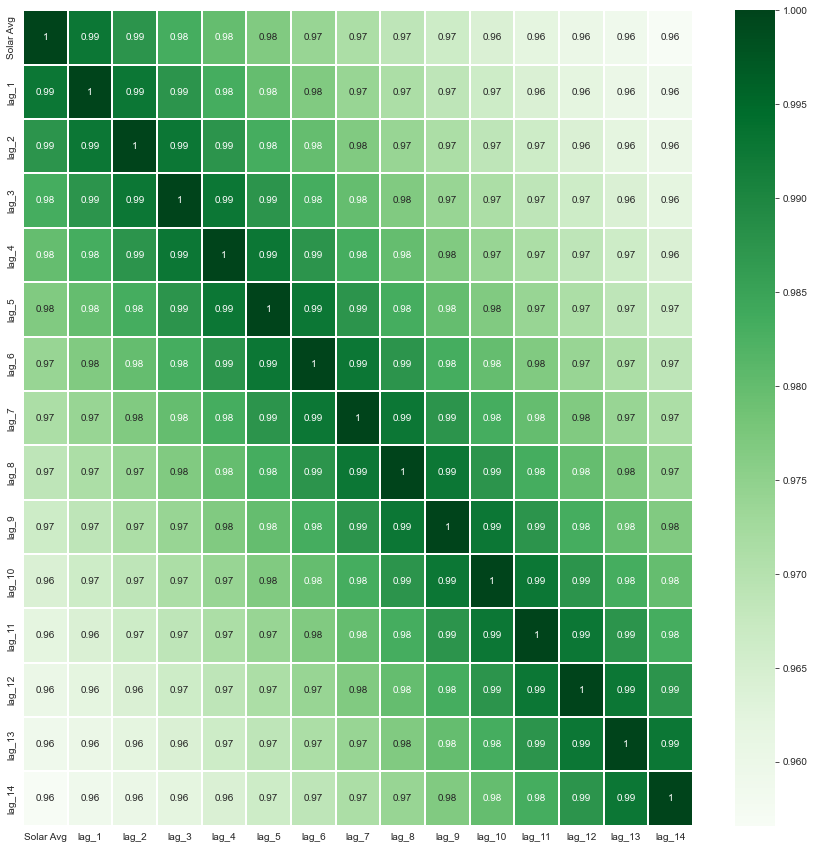

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":10});

In [14]:
# Creating train and test sets:
X = data.drop(['Solar Avg'], axis =1)
y = data['Solar Avg'].to_frame()

# Scaling the data. 
data_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(X.values)
scaled_target = target_scaler.fit_transform(y.values)

scaled_data= pd.DataFrame(scaled_data, index=X.index, columns=X.columns)
scaled_target= pd.DataFrame(scaled_target, index=y.index, columns=y.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_data,scaled_target,test_size=0.2,shuffle=False, stratify = None)

this code performs data preprocessing tasks by splitting the original dataset into features and target dataframes, standardizing the data using the StandardScaler class, and splitting the data into training and testing sets using the train_test_split function.

## LSTM:

In [22]:
# Import necessary libraries
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras import optimizers

# Define a function that creates the LSTM model
def create_lstm_model(learning_rate=0.001, units_1=128, units_2=64):
    model = Sequential()
    model.add(LSTM(units_1, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units_2, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    print('#',end='')
    return model

# Create a KerasRegressor from the function above
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Define the hyperparameters to tune and their possible values
param_grid = {'learning_rate': [0.001, 0.01, 0.1], 'units_1': [64, 128, 256], 'units_2': [32, 64, 128]}

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train.iloc[:10000], y_train.iloc[:10000])

# Print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

########################################################################################################################################Best: -0.027327 using {'learning_rate': 0.01, 'units_1': 256, 'units_2': 128}


this code performs hyperparameter tuning for an LSTM model by creating a function that defines the model architecture, creating a KerasRegressor object from the function, defining a dictionary of hyperparameters to tune, and using GridSearchCV to find the best hyperparameters.

In [ ]:
lstm_model = create_lstm_model(learning_rate=grid_result.best_params_['learning_rate'],
                          units_1=grid_result.best_params_['units_1'],
                          units_2=grid_result.best_params_['units_2'])

lstm_model.fit(x_train, y_train, epochs=2)

This code trains the LSTM model with the best hyperparameters found using GridSearchCV in the previous code block.

In [25]:
LSTMpredictions = lstm_model.predict(x_test)
LSTMpredictions = target_scaler.inverse_transform(LSTMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
lstmmae = mean_absolute_error(y_test_descaled, LSTMpredictions)
lstmmse = mean_squared_error(y_test_descaled, LSTMpredictions)
lstmrmse = np.sqrt(lstmmse)
lstmr2 = r2_score(y_test_descaled, LSTMpredictions)
lstmaic = aic(y_test, LSTMpredictions, x_test)
lstmmape = mean_absolute_percentage_error(y_test, LSTMpredictions) * 100
print(f'''
(a) LSTM Mean Absolute Error (lstmMAE): {lstmmae}
(b) LSTM Mean Squared Error (MlstmSE): {lstmmse}
(c) LSTM Root Mean Squared Errlstmor (RMSE): {lstmrmse}
(d) LSTM R² (R-Squared):{lstmr2}
(e) LSTM AIC : {lstmaic.iloc[0]}
(f) LSTM MAPE : {lstmmape}
''')


(a) LSTM Mean Absolute Error (lstmMAE): 19.915842472133658
(b) LSTM Mean Squared Error (MlstmSE): 2566.9507221814783
(c) LSTM Root Mean Squared Errlstmor (RMSE): 50.665083856453634
(d) LSTM R² (R-Squared):0.9742648639406296
(e) LSTM AIC : -18.04228012338192
(f) LSTM MAPE : 383870.1397464409



#### Plotting the LSTM predictions:

In [46]:
train = data[:len(x_train)]
lstmvalid = data[len(x_train):]
lstmvalid['Predictions'] = LSTMpredictions

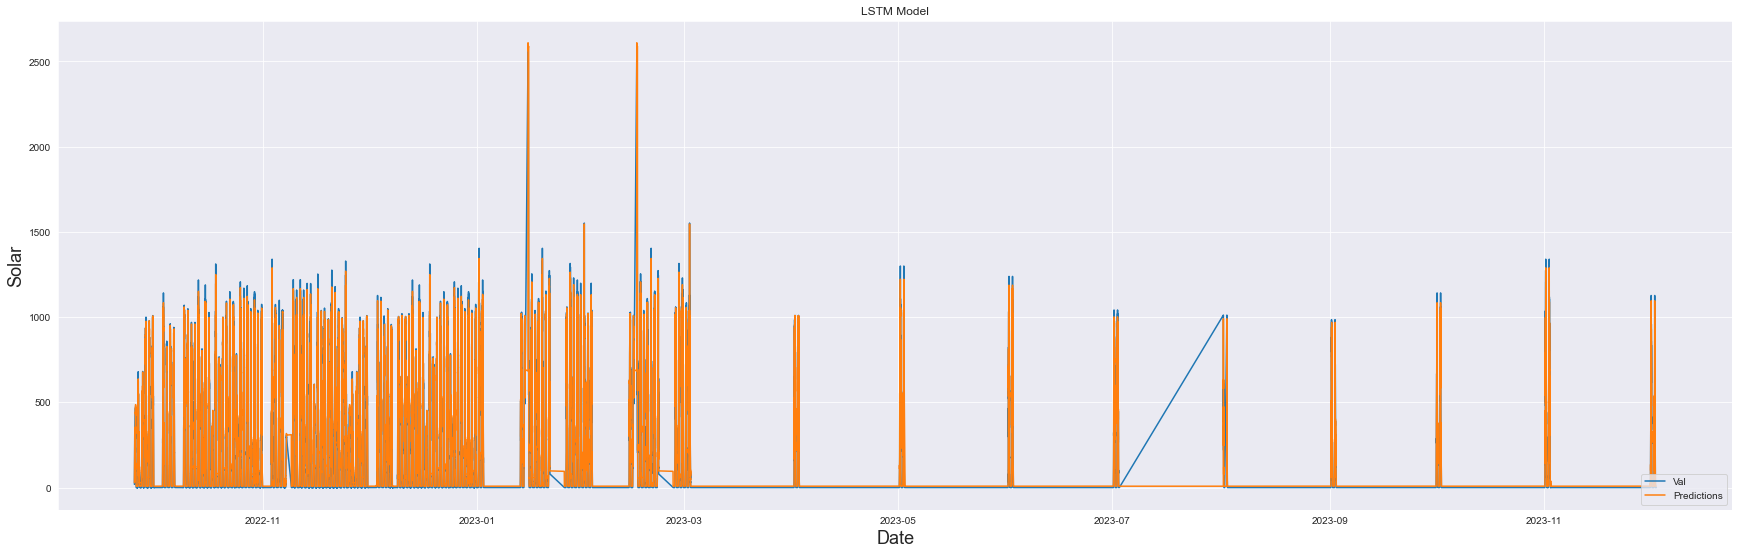

In [47]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(lstmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [48]:
lstmvalid.to_csv('LSTM predictions.csv')

## ELM:

In [29]:
# define the model
def create_elm_model(hidden_units=64, activation='relu', learning_rate=0.001):
    elm_model = Sequential()
    elm_model.add(Dense(hidden_units, input_dim=x_train.shape[1], activation=activation, kernel_initializer='he_uniform'))
    elm_model.add(Dense(1))
    optimizer = optimizers.Adam(lr=learning_rate)
    elm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    print('#',end='')
    return elm_model

# create a dictionary of hyperparameters to tune
hyperparameters = {'hidden_units': [32, 64, 128],
                   'activation': ['relu', 'tanh', 'sigmoid'],
                   'learning_rate': [0.001, 0.01, 0.1]}

# create a GridSearchCV object
elm_model = KerasRegressor(build_fn=create_elm_model, verbose=0)
grid_search = GridSearchCV(estimator=elm_model, param_grid=hyperparameters, cv=5)

# perform the grid search
grid_result = grid_search.fit(x_train.iloc[:10000], y_train.iloc[:10000], batch_size = 1000, epochs = 10)

# print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

########################################################################################################################################Best: -0.019817 using {'activation': 'sigmoid', 'hidden_units': 64, 'learning_rate': 0.1}


This code performs hyperparameter tuning using GridSearchCV for an ELM model with a single hidden layer, by testing different combinations of the number of hidden units, activation function, and learning rate, and finds the best hyperparameters that give the highest score.

In [31]:
grid_result.best_params_

{'activation': 'sigmoid', 'hidden_units': 64, 'learning_rate': 0.1}

In [33]:
elm_model = create_elm_model(activation=grid_result.best_params_['activation'],
                          hidden_units=grid_result.best_params_['hidden_units'],
                          learning_rate=grid_result.best_params_['learning_rate'])

elm_model.fit(x_train, y_train, epochs=3)

#Epoch 1/3
23281/23281 [==============================] - 16s 679us/step - loss: 0.0367
Epoch 2/3
23281/23281 [==============================] - 16s 674us/step - loss: 0.0322
Epoch 3/3
23281/23281 [==============================] - 16s 677us/step - loss: 0.0324


This code trains the ELM model with the best hyperparameters found using GridSearchCV in the previous code block.

In [35]:
ELMpredictions = elm_model.predict(x_test)
ELMpredictions = target_scaler.inverse_transform(ELMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
ELMmae = mean_absolute_error(y_test_descaled, ELMpredictions)
ELMmse = mean_squared_error(y_test_descaled, ELMpredictions)
ELMrmse = np.sqrt(ELMmse)
ELMr2 = r2_score(y_test_descaled, ELMpredictions)
ELMaic = aic(y_test, ELMpredictions, x_test)
ELMmape = mean_absolute_percentage_error(y_test, ELMpredictions) * 100
print(f'''
(a) ELM Mean Absolute Error (ELMMAE): {ELMmae}
(b) ELM Mean Squared Error (MELMSE): {ELMmse}
(c) ELM Root Mean Squared ErrELMor (RMSE): {ELMrmse}
(d) ELM R² (R-Squared):{ELMr2}
(e) ELM AIC : {ELMaic.iloc[0]}
(f) ELM MAPE : {ELMmape}
''')

5821/5821 [==============================] - 3s 586us/step

(a) ELM Mean Absolute Error (ELMMAE): 32.72658257132143
(b) ELM Mean Squared Error (MELMSE): 5561.013696870514
(c) ELM Root Mean Squared ErrELMor (RMSE): 74.57220458636391
(d) ELM R² (R-Squared):0.9442476854423747
(e) ELM AIC : -17.665037322431814
(f) ELM MAPE : 294624.6688481707



#### Plotting the ELM predictions:

In [49]:
train = data[:len(x_train)]
elmvalid = data[len(x_train):]
elmvalid['Predictions'] = ELMpredictions

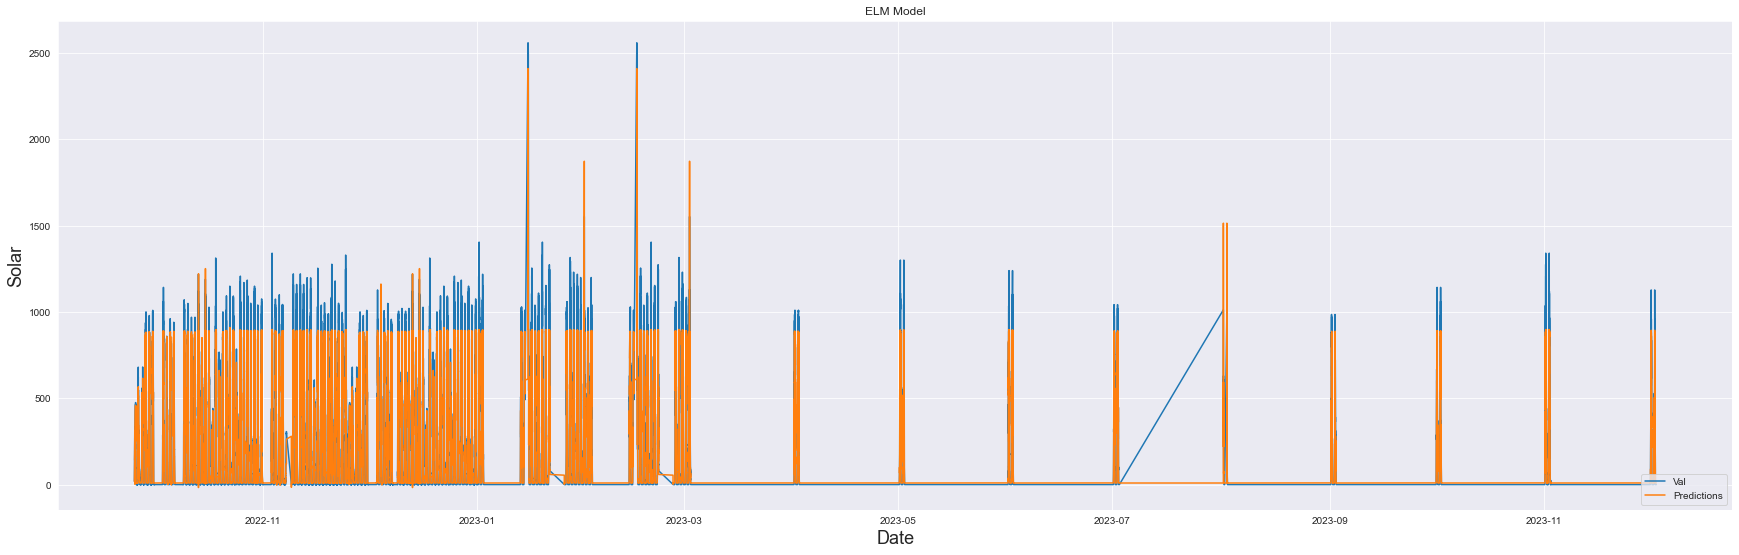

In [50]:
plt.figure(figsize=(30,9))
plt.title('ELM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(elmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [51]:
elmvalid.to_csv('ELM predictions.csv')

## Hypered-Model:

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate, Dense

# Create a new input layer for your ensemble model
input_layer = Input(shape=(X.shape[1],))

# Get the output from the LSTM model and ELM model
lstm_output = lstm_model(input_layer)
elm_output = elm_model(input_layer)

# Concatenate the outputs
concat_output = Concatenate()([lstm_output, elm_output])

# Add a dense layer to the concatenated output
dense_output = Dense(1)(concat_output)

# Create a new model that takes the input layer and produces the dense output
ensemble_model = Model(inputs=input_layer, outputs=dense_output)

# Compile the ensemble model
ensemble_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the ensemble model
ensemble_model.fit(x_train, y_train, epochs=1)


This code is creating an ensemble model that combines the output of two previously trained models, an LSTM model (lstm_model) and an ELM model (elm_model).

First, an input layer is created with the same shape as the input data used to train the two models. Then, the output from both models is obtained by passing the input layer as input to each model. The output of the two models is concatenated using the Concatenate() layer.

After the concatenation, a dense layer is added to the concatenated output. The output of this dense layer is then passed as output to a new model, called the ensemble_model, which takes the input layer and produces the dense output.

Finally, the ensemble_model is compiled with the mean squared error as loss function and the Adam optimizer. The model is then trained using the training data with 40 epochs.

In [40]:
Hyperedpredictions = ensemble_model.predict(x_test)
Hyperedpredictions = target_scaler.inverse_transform(Hyperedpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
Hyperedmae = mean_absolute_error(y_test_descaled, Hyperedpredictions)
Hyperedmse = mean_squared_error(y_test_descaled, Hyperedpredictions)
Hyperedrmse = np.sqrt(Hyperedmse)
Hyperedr2 = r2_score(y_test_descaled, Hyperedpredictions)
Hyperedaic = aic(y_test, Hyperedpredictions, x_test)
Hyperedmape = mean_absolute_percentage_error(y_test, Hyperedpredictions) * 100
print(f'''
(a) Hypered Mean Absolute Error (HyperedMAE): {Hyperedmae}
(b) Hypered Mean Squared Error (MHyperedSE): {Hyperedmse}
(c) Hypered Root Mean Squared ErrHyperedor (RMSE): {Hyperedrmse}
(d) Hypered R² (R-Squared):{Hyperedr2}
(e) Hypered AIC : {Hyperedaic.iloc[0]}
(f) Hypered MAPE : {Hyperedmape}
''')

5821/5821 [==============================] - 276s 47ms/step

(a) Hypered Mean Absolute Error (HyperedMAE): 14.28622251758993
(b) Hypered Mean Squared Error (MHyperedSE): 2421.4338027405392
(c) Hypered Root Mean Squared ErrHyperedor (RMSE): 49.208066439767165
(d) Hypered R² (R-Squared):0.9757237535439214
(e) Hypered AIC : -17.98199685816236
(f) Hypered MAPE : 363941.6395368398



#### Plotting the Hypered-model predictions:

In [41]:
train = data[:len(x_train)]
hyvalid = data[len(x_train):]
hyvalid['Predictions'] = Hyperedpredictions

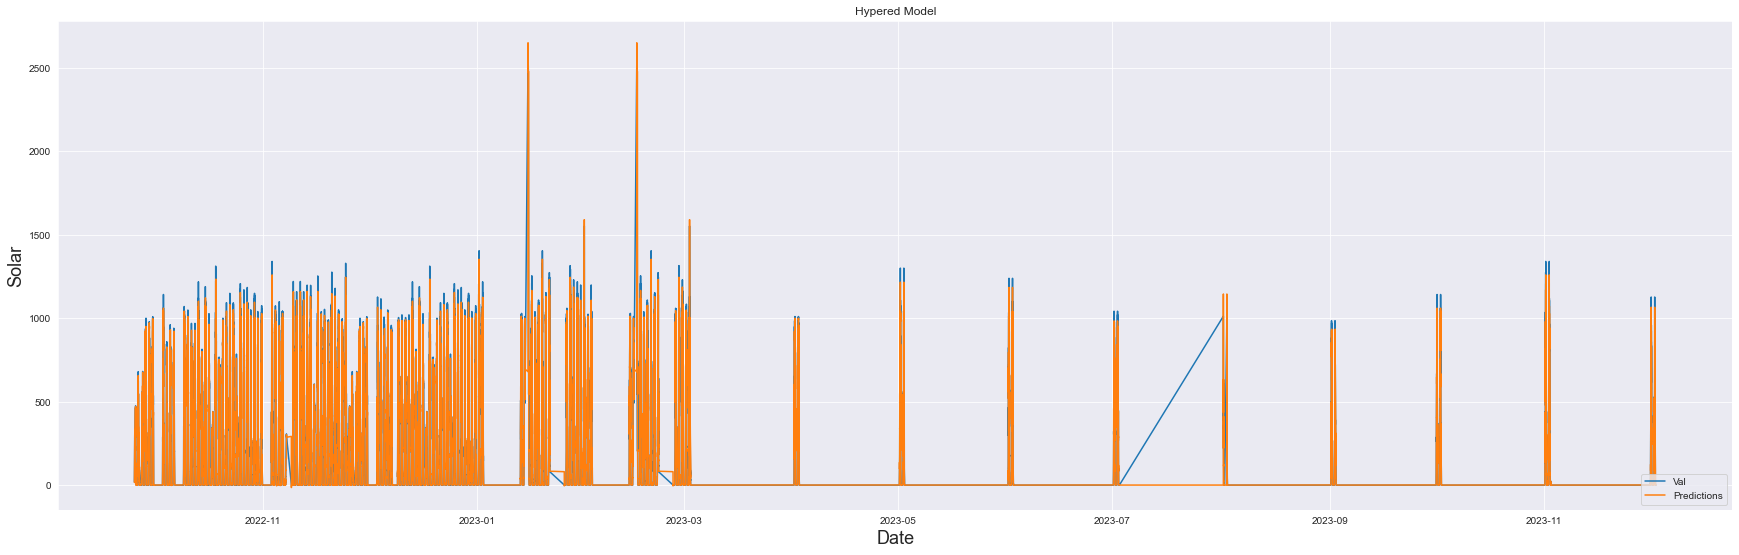

In [42]:
plt.figure(figsize=(30,9))
plt.title('Hypered Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(hyvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [43]:
hyvalid.to_csv('Hypered predictions.csv')

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create three line plots with two lines each
trace1 = go.Scatter(x=hyvalid.index, y=lstmvalid.Predictions, name='LSTM Predictions')
trace2 = go.Scatter(x=hyvalid.index, y=lstmvalid['Solar Avg'], name='True Value')
trace3 = go.Scatter(x=hyvalid.index, y=elmvalid.Predictions, name='ELM Predictions')
trace4 = go.Scatter(x=hyvalid.index, y=elmvalid['Solar Avg'], name='True Value')
trace5 = go.Scatter(x=hyvalid.index, y=hyvalid.Predictions, name='Hypered Predictions')
trace6 = go.Scatter(x=hyvalid.index, y=hyvalid['Solar Avg'], name='True Value')

# Create a subplot with three rows and two columns
fig = make_subplots(rows=3, cols=2)

# Add the six line plots to the subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=1)
fig.add_trace(trace4, row=2, col=1)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace5, row=3, col=1)
fig.add_trace(trace6, row=3, col=1)

# Update the subplot layout
fig.update_layout(height=900, width=2000, title_text="Solar Predictions")

# Save the subplot to a file
fig.write_html("subplot.html")